In [6]:

!pip install scikit-learn seaborn matplotlib pandas


In [10]:
import os
import zipfile
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import accuracy_score, classification_report, ConfusionMatrixDisplay

In [11]:
def ensure_extracted(zip_path: str, extract_dir: str):
    """Extract *zip_path* into *extract_dir* unless *extract_dir* already exists."""
    if not os.path.exists(extract_dir):
        assert os.path.exists(zip_path), f"ZIP file {zip_path} not found. Please upload it."
        with zipfile.ZipFile(zip_path, 'r') as z:
            z.extractall(extract_dir)
        print(f"✔️ Extracted {zip_path} → {extract_dir}")
    else:
        print(f"✔️ {extract_dir} already present – extraction skipped.")

In [12]:
FULL_ZIP   = "bank-additional.zip"   # preferred full dataset
SMALL_ZIP  = "bank.zip"              # fallback smaller dataset
BASE_DIR   = "bank_data"             # folder all data go into

if os.path.exists(os.path.join(BASE_DIR, "bank-additional", "bank-additional-full.csv")):
    print("✔️ Full dataset already present.")
else:
    if os.path.exists(FULL_ZIP):
        ensure_extracted(FULL_ZIP, BASE_DIR)
    elif os.path.exists(SMALL_ZIP):
        ensure_extracted(SMALL_ZIP, BASE_DIR)
    else:
        raise FileNotFoundError("Neither bank-additional.zip nor bank.zip found. Upload one of them and rerun.")

✔️ bank_data already present – extraction skipped.


In [14]:
FULL_CSV  = os.path.join(BASE_DIR, "bank-additional", "bank-additional-full.csv")
SMALL_CSV = os.path.join(BASE_DIR, "bank.csv")

if os.path.exists(FULL_CSV):
    CSV_PATH = FULL_CSV
    dataset_version = "FULL (41 188 rows)"
elif os.path.exists(SMALL_CSV):
    CSV_PATH = SMALL_CSV
    dataset_version = "SMALL (4 521 rows)"
else:
    raise FileNotFoundError("CSV file not found after extraction. Check ZIP contents.")

print(f"Using {dataset_version} dataset → {CSV_PATH}")
      

Using SMALL (4 521 rows) dataset → bank_data\bank.csv


Shape of dataset: (4521, 17)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4521 entries, 0 to 4520
Data columns (total 17 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   age        4521 non-null   int64 
 1   job        4521 non-null   object
 2   marital    4521 non-null   object
 3   education  4521 non-null   object
 4   default    4521 non-null   object
 5   balance    4521 non-null   int64 
 6   housing    4521 non-null   object
 7   loan       4521 non-null   object
 8   contact    4521 non-null   object
 9   day        4521 non-null   int64 
 10  month      4521 non-null   object
 11  duration   4521 non-null   int64 
 12  campaign   4521 non-null   int64 
 13  pdays      4521 non-null   int64 
 14  previous   4521 non-null   int64 
 15  poutcome   4521 non-null   object
 16  y          4521 non-null   object
dtypes: int64(7), object(10)
memory usage: 600.6+ KB
None

Target class distribution (y):
 y
no     4000
yes     521
Name: 

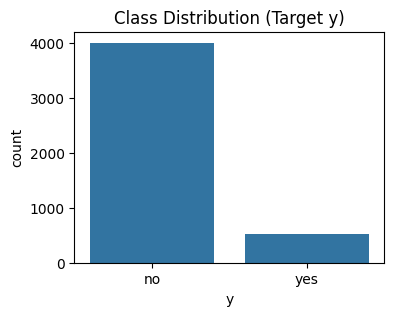

In [15]:
df = pd.read_csv(CSV_PATH, sep=';')
print("Shape of dataset:", df.shape)
df.head()


print(df.info())
print("\nTarget class distribution (y):\n", df['y'].value_counts())
plt.figure(figsize=(4,3))
sns.countplot(x='y', data=df)
plt.title("Class Distribution (Target y)")
plt.show()

In [16]:
df_encoded = df.copy()
for col in df_encoded.select_dtypes(include=['object']).columns:
    if col != 'y':
        df_encoded[col] = LabelEncoder().fit_transform(df_encoded[col])
le_y = LabelEncoder()
y = le_y.fit_transform(df_encoded['y'])
X = df_encoded.drop('y', axis=1)

In [17]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42)


In [18]:
model = DecisionTreeClassifier(
    max_depth=4,
    random_state=42,
    class_weight='balanced'
)
model.fit(X_train, y_train)

,criterion,'gini'
,splitter,'best'
,max_depth,4
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,None
,random_state,42
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,class_weight,'balanced'


In [19]:
y_pred = model.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred, target_names=le_y.classes_))

Accuracy: 0.7292817679558011

Classification Report:
               precision    recall  f1-score   support

          no       0.97      0.71      0.82       801
         yes       0.28      0.85      0.42       104

    accuracy                           0.73       905
   macro avg       0.63      0.78      0.62       905
weighted avg       0.89      0.73      0.78       905



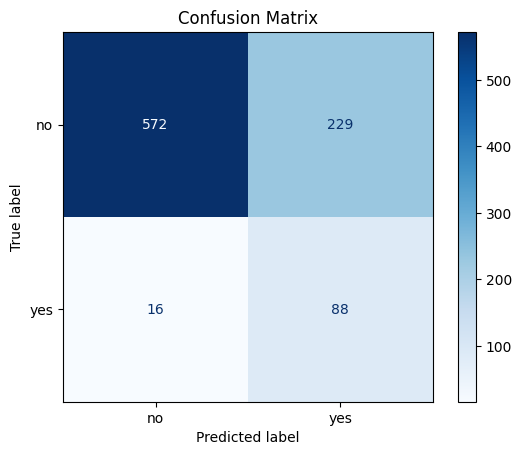

In [20]:
ConfusionMatrixDisplay.from_estimator(
    model, X_test, y_test,
    display_labels=le_y.classes_,
    cmap='Blues',
    values_format='d'
)
plt.title("Confusion Matrix")
plt.show()


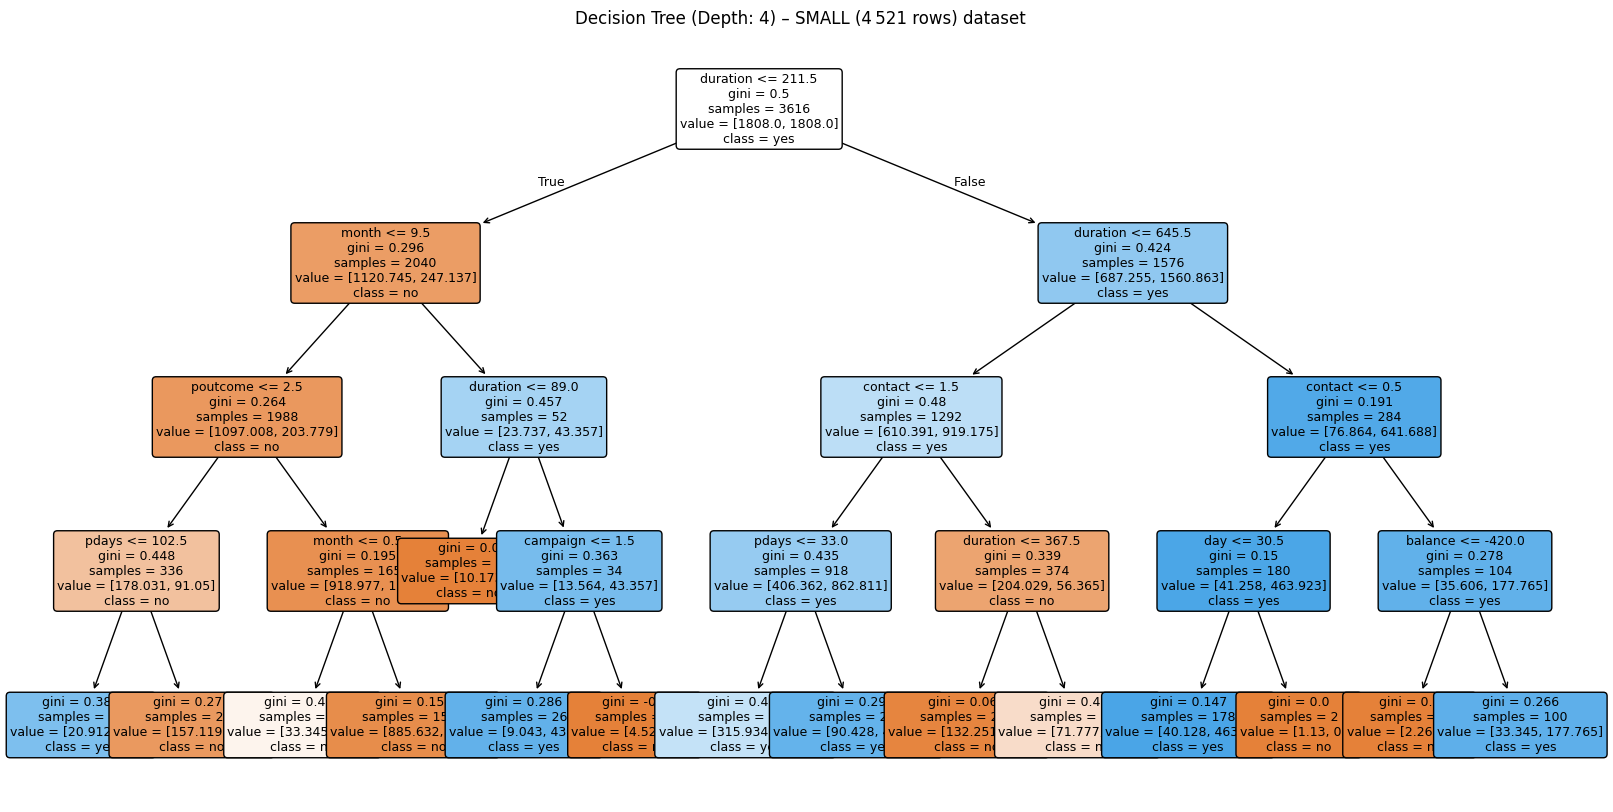

In [21]:
plt.figure(figsize=(20, 10))
plot_tree(model,
          feature_names=X.columns,
          class_names=le_y.classes_,
          filled=True,
          rounded=True,
          fontsize=9)
plt.title(f"Decision Tree (Depth: {model.get_depth()}) – {dataset_version} dataset")
plt.show()


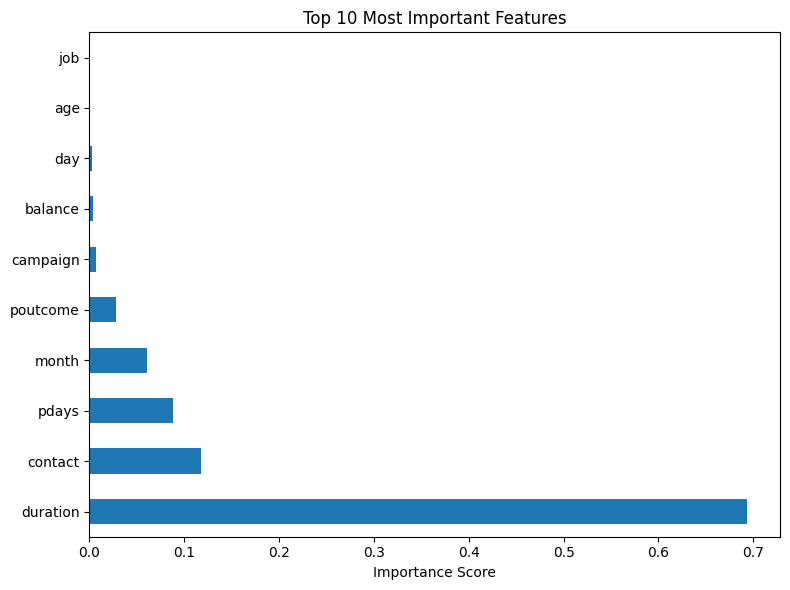

In [22]:
feat_imp = pd.Series(model.feature_importances_, index=X.columns)
plt.figure(figsize=(8,6))
feat_imp.nlargest(10).plot(kind='barh')
plt.title("Top 10 Most Important Features")
plt.xlabel("Importance Score")
plt.tight_layout()
plt.show()